In [3]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 172.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 208.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 50.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 84.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 217.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 253.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 270.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 181.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 261.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 54.0 MB

In [5]:
! pip install matplotlib tqdm

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 112.3 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 164.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 117.7 MB/s eta 0:00:00
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [4]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA


In [6]:
with open("./data/text8_train.txt", "r") as f:     
    train_text = f.read() 
with open("./data/text8_test.txt", "r") as f:     
    test_text = f.read()

print(f"Training text length: {len(train_text):,} characters")
print(f"Test text length: {len(test_text):,} characters")
print(f"Sample: '{train_text[:100]}'")

Training text length: 90,000,000 characters
Test text length: 5,000,000 characters
Sample: ' anarchism originated as a term of abuse first used against early working class radicals including t'


In [7]:
# Create character vocabulary
chars = sorted(list(set(train_text + test_text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {chars}")

# Create character to index and index to character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"\nchar_to_idx: {char_to_idx}")

Vocabulary size: 27
Characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

char_to_idx: {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [8]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx
        
        # Create sequences
        self.data = []
        for i in range(len(text) - seq_length):
            seq = text[i:i + seq_length]
            target = text[i + seq_length]
            self.data.append((seq, target))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        seq, target = self.data[idx]
        # Convert to indices
        seq_idx = torch.tensor([self.char_to_idx[ch] for ch in seq], dtype=torch.long)
        target_idx = torch.tensor(self.char_to_idx[target], dtype=torch.long)
        return seq_idx, target_idx

In [9]:
# Hyperparameters
SEQ_LENGTH = 50  # Length of input sequences (reduced from 100)
BATCH_SIZE = 256  # Increased for faster training
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
LEARNING_RATE = 0.002
NUM_EPOCHS = 3  # Start with 1 epoch for testing
DROPOUT = 0.3

# Optional: Use subset of data for faster initial training
USE_SUBSET = True
SUBSET_SIZE = 25_000_000  # Use 25M characters instead of full dataset

if USE_SUBSET:
    train_text_subset = train_text[:SUBSET_SIZE]
    test_text_subset = test_text[:min(SUBSET_SIZE // 10, len(test_text))]
    print(f"Using subset: {len(train_text_subset):,} train chars, {len(test_text_subset):,} test chars")
else:
    train_text_subset = train_text
    test_text_subset = test_text

Using subset: 25,000,000 train chars, 2,500,000 test chars


In [10]:
print("Creating datasets...")
train_dataset = CharDataset(train_text_subset, SEQ_LENGTH, char_to_idx)
test_dataset = CharDataset(test_text_subset, SEQ_LENGTH, char_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Number of training sequences: {len(train_dataset):,}")
print(f"Number of test sequences: {len(test_dataset):,}")
print(f"Number of training batches: {len(train_loader):,}")

Creating datasets...
Number of training sequences: 24,999,950
Number of test sequences: 2,499,950
Number of training batches: 97,657


In [11]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(CharLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                        batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)
        
        # Take the last output
        lstm_out = self.dropout(lstm_out[:, -1, :])  # (batch_size, hidden_dim)
        output = self.fc(lstm_out)  # (batch_size, vocab_size)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

In [12]:
model = CharLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

CharLSTM(
  (embedding): Embedding(27, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=27, bias=True)
)

Total parameters: 931,995
Trainable parameters: 931,995


In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [14]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...\n")
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")

print("Training completed!")

Starting training...

Epoch 1/3


Evaluating: 100%|██████████| 9766/9766 [01:39<00:00, 98.36it/s]


Train Loss: 1.4908, Train Acc: 54.19%
Test Loss: 1.4101, Test Acc: 56.30%

Epoch 2/3


Evaluating: 100%|██████████| 9766/9766 [01:40<00:00, 97.29it/s]


Train Loss: 1.6971, Train Acc: 48.29%
Test Loss: 2.2122, Test Acc: 33.27%

Epoch 3/3


Evaluating: 100%|██████████| 9766/9766 [01:40<00:00, 97.60it/s]

Train Loss: 2.4870, Train Acc: 27.04%
Test Loss: 2.4782, Test Acc: 27.78%

Training completed!


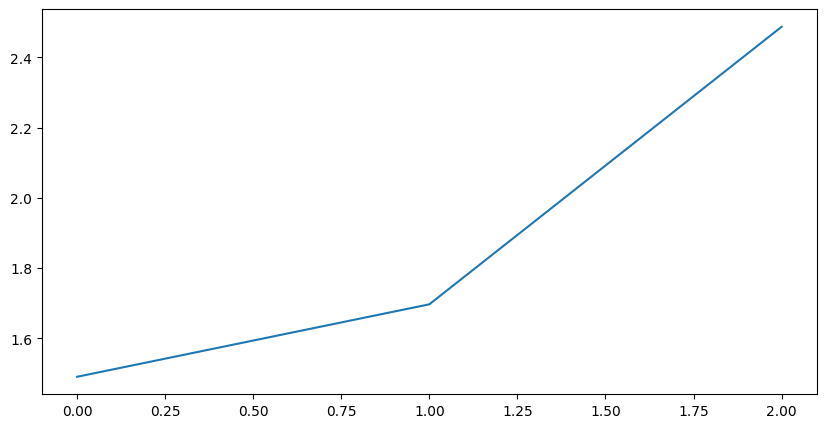

In [15]:
plot_loss = np.array(train_losses)
plt.figure(figsize=(10,5))
plt.plot(plot_loss)

In [16]:
def generate_text(model, start_string, char_to_idx, idx_to_char, device, 
                  length=500, temperature=1.0):
    """
    Generate text using the trained model
    
    Args:
        model: Trained LSTM model
        start_string: String to start generation
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
        device: Device to run on
        length: Number of characters to generate
        temperature: Sampling temperature (higher = more random)
    """
    model.eval()
    
    # Convert start string to indices
    input_seq = [char_to_idx.get(ch, 0) for ch in start_string.lower()]
    generated = start_string.lower()
    
    with torch.no_grad():
        for _ in range(length):
            # Prepare input
            x = torch.tensor(input_seq[-SEQ_LENGTH:], dtype=torch.long).unsqueeze(0).to(device)
            
            # Pad if necessary
            if x.size(1) < SEQ_LENGTH:
                padding = torch.zeros((1, SEQ_LENGTH - x.size(1)), dtype=torch.long).to(device)
                x = torch.cat([padding, x], dim=1)
            
            # Get prediction
            output, _ = model(x)
            output = output.squeeze()
            
            # Apply temperature
            output = output / temperature
            probs = torch.softmax(output, dim=0)
            
            # Sample from distribution
            predicted_idx = torch.multinomial(probs, 1).item()
            predicted_char = idx_to_char[predicted_idx]
            
            generated += predicted_char
            input_seq.append(predicted_idx)
    
    return generated

In [18]:
# Generate text samples with different seeds
print("=" * 80)
print("GENERATED TEXT SAMPLES")
print("=" * 80)

seeds = ["hello my fri ", "the "]
temperatures = [0.5, 0.8, 1.0]

for seed in seeds:
    print(f"\n{'='*80}")
    print(f"Seed: '{seed}'")
    print(f"{'='*80}")
    
    for temp in temperatures:
        print(f"\n--- Temperature: {temp} ---")
        generated = generate_text(model, seed, char_to_idx, idx_to_char, device, 
                                 length=300, temperature=temp)
        print(generated)
        print()

GENERATED TEXT SAMPLES

Seed: 'hello my fri '

--- Temperature: 0.5 ---
hello my fri ather ano sev altis the an  eorinae fthe at whe ihe theen on the ne oo mhe ior the bes this smamai hedev in  andand asminit hee the ais itor ofreeithed ca ton mateee red ton con torle binedren d fnes the thee ee artwe andid  isce malame use heln see  of the of atin tee the theirne the oure s itionn 


--- Temperature: 0.8 ---
hello my fri moum ou bled oniticny itien no tea lhar minnyi aneeo  iasene pasisia  aluyne nohneel satwro ofr eee neee ier sove alandeastld se s ais achon ofe the r coew r hiatuo con aer eaicfmarofre an the sicg athg torisiont  honyw no fner bo c iletatoue iionr on espss an io to t freto the busents deas ors the 


--- Temperature: 1.0 ---
hello my fri ollionll ioebuv heaplna stelme the oubeder secn tuermenede wad aseerd thesian c ho tha fthit asppiiet jr e he to fcdpaflaro tbce blwv eis timeruwins bco sibiteyt thsntmas joc leache dieidn ice stajaaan kaner pfecet annfr or fzescrtse